<center><h1><strong>Data Science EDA</strong></h1><center>

This notebook contains exploratory data analysis of Data Science Roles, Skills & Salaries 2025 dataset from Kaggle (https://www.kaggle.com/datasets/sidraaazam/data-science-roles-skills-and-salaries-2025). The purpose of this analysis is for me to practice some basic EDA and Python skills with a dataset that will hopefully provide insights that inform my own self-education and job search in the field of data analytics and data science.

Here are the main questions guiding my analysis:
1. What skills are highly sought after among Data Science roles and which skills are most desired (as reflected in salaries)?
2. How are jobs and skills distributed across industries?
3. Do insights gained through this EDA provide guidance for my own skill and portfolio development?

As is my personal preference, the code contained herein is heavily editorialized with comments. The notebook will also conclude with a summary of skills, tools, and resources used.

<h2><strong>Data</strong></h2>

In [77]:
## importing modules that are probably just generically useful for most data analysis scripts.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from sklearn.linear_model import LinearRegression
from collections import Counter
import seaborn as sns
import os
import sys

## Now it's time to get that data...
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "data_science_job_posts_2025 (2).csv"

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,"sidraaazam/data-science-roles-skills-and-salaries-2025",file_path)

<h2><strong>Cleaning</strong></h2>

I'll start with salaries. After taking a look at the dataset, I've realized that salaries are all presented in '€' (thankfully).

Some are presented as single values, while others are ranges. I'd like to strip out the '€' symbols, commas, and convert ranges to averages.

I'll define a function that will clean this up for me.

In [78]:
def salary_clean(salary):
    if pd.isna(salary):
        return np.nan
    salary = salary.replace('€', '').replace(',', '').strip()
    if '-' in salary:
        low, high = salary.split('-')
        return (float(low) + float(high)) / 2
    else:
        try:
            return float(salary)
        except ValueError:
            return np.nan

## Now I'll apply this function to the 'Salary' column in the dataframe, since I'll need this cleaned version from the start.
df['Cleaned_Salary'] = df['salary'].apply(salary_clean).astype(float)

Early analysis revealed that there are three strongly outlying salaries in the dataset.
In order to avoid repeated skewing of results, I mostly worked with a filtered version of the dataset.

In [79]:
df_filtered = df[df['Cleaned_Salary'] < 600000].copy()

Similarly to the salaries, I'll need a function to clean up revenues.

This will remove the € symbol and the trailing M, T, and B characters while converting all values to floats (in billions of Euros).

In [80]:
def rev_clean(rev):
         if pd.isna(rev):
             return np.nan
         if rev in ['Public', 'Private', 'Education', 'Nonprofit']:
             return np.nan
         rev = rev.replace('€', '').replace(',', '').strip()
         if rev.endswith('B'):
             return float(rev[:-1])
         if rev.endswith('T'):
             return float(rev[:-1])*1000
         if rev.endswith('M'):
             return float(rev[:-1])/1000

## Now we'll apply the function to our filtered dataset.
df_filtered.loc[:,'Cleaned_Revenue'] = df_filtered['revenue'].apply(rev_clean).astype(float)

When looking at how seniority level affects salary, I'll lump junior + midlevel (junior) and senior + lead roles (senior) in a new Seniority_Binary field.

In [81]:
df_filtered.loc[:, 'Seniority_Binary'] = df_filtered['seniority_level'].apply(lambda x: 'junior' if x in ['junior', 'midlevel'] else 'senior' if pd.notna(x) else np.nan)

During the skills analysis, I'll need lists of the individual skills for Junior roles...

In [82]:
jr_subset = df_filtered[df_filtered['Seniority_Binary'] == 'junior']['skills'].dropna()
jr_skill_counter = Counter()
for skills in jr_subset:
    skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
    jr_skill_counter.update(skill_list)
most_common_jr_skills = jr_skill_counter.most_common(25)

... and for Senior roles.

In [83]:
sr_subset = df_filtered[df_filtered['Seniority_Binary'] == 'senior']['skills'].dropna()
sr_skill_counter = Counter()
for skills in sr_subset:
    skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
    sr_skill_counter.update(skill_list)
most_common_sr_skills = sr_skill_counter.most_common(25)

<h2><strong>Exploratory Data Analysis</strong></h2>

<h3>Salaries and Seniority Levels</h3>

With our cleaned up salary info, we'll first make a histogram to view the distribution of salaries.

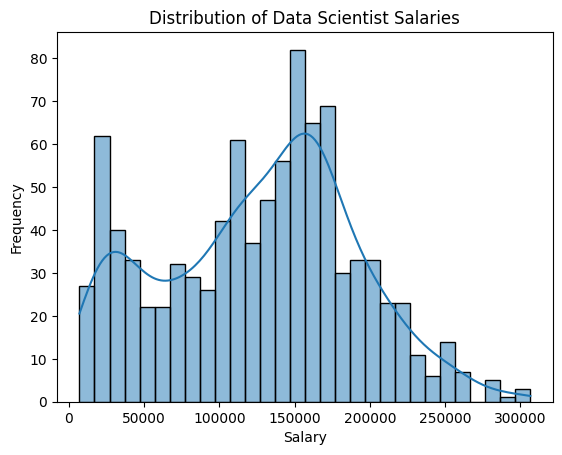

In [84]:
sns.histplot(data=df_filtered['Cleaned_Salary'],bins=30, edgecolor='black', kde=True)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Data Scientist Salaries')
plt.grid(False)
plt.show()  

Next, let's see what the distribution of salaries looks like when broken down by seniority level.

We'll look at this one with a boxplot.

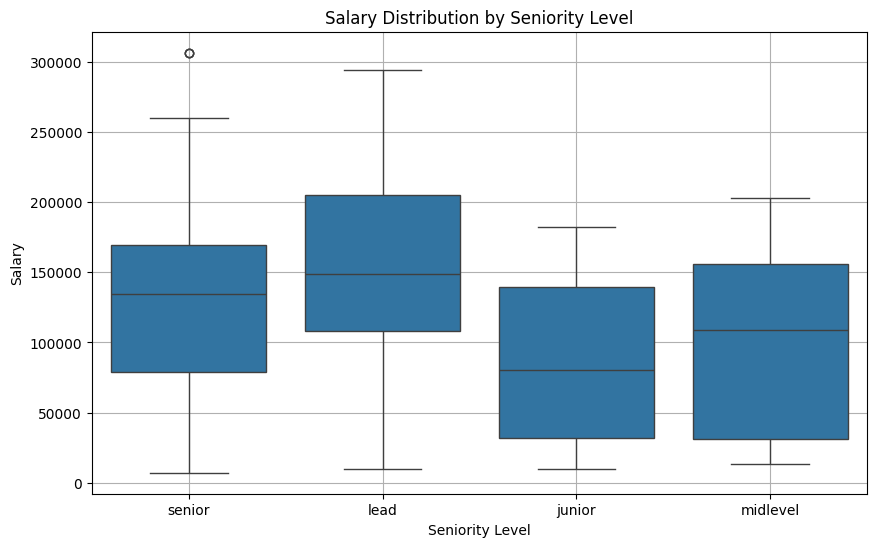

In [85]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='seniority_level', y='Cleaned_Salary', data=df_filtered)
plt.xlabel('Seniority Level')
plt.ylabel('Salary')
plt.title('Salary Distribution by Seniority Level')
plt.grid(True)
plt.show()

The boxplot suggests that "junior" and "midlevel" might not really be meaningful distinctions.

We can examine this a bit further by making histograms of salaries by seniority level and viewing them all together on one plot.


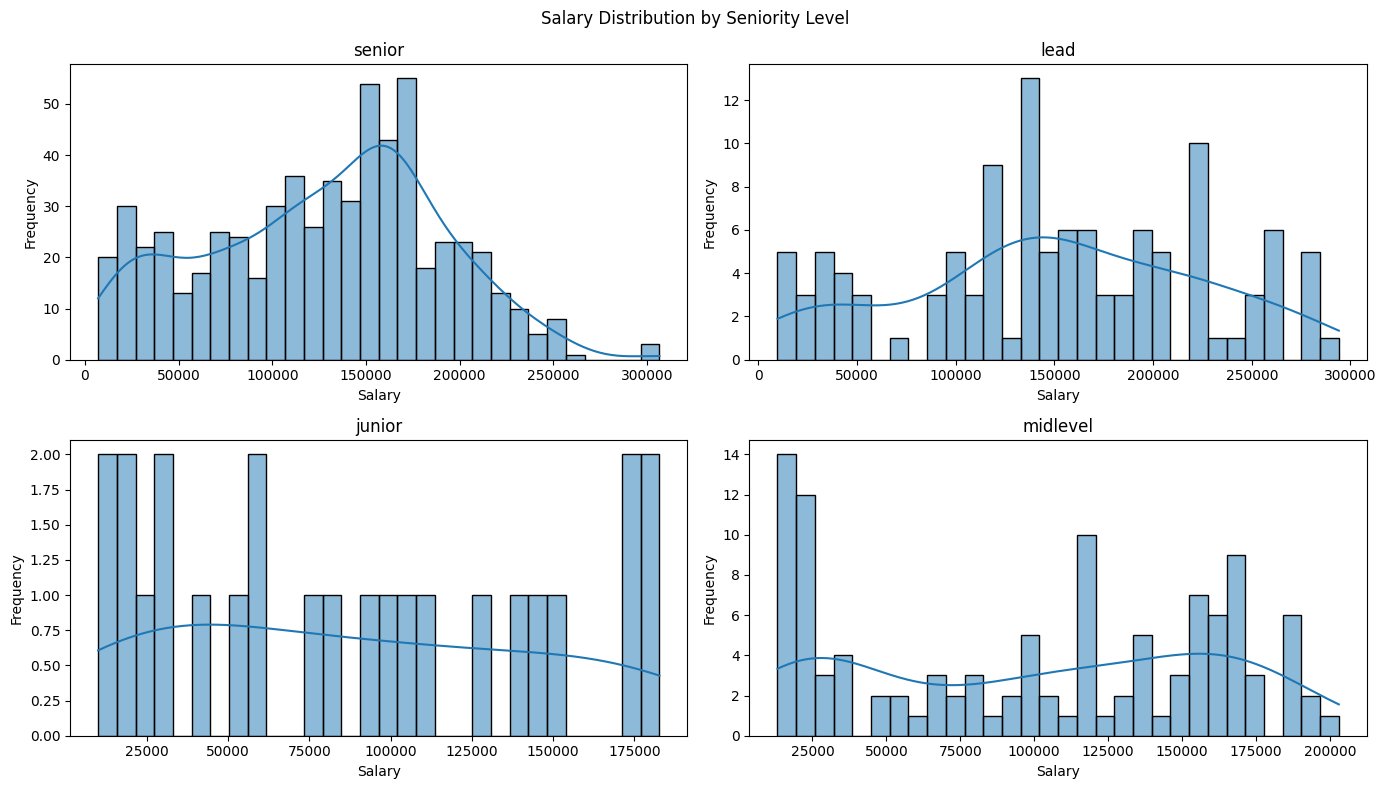

In [86]:
experience_levels = df_filtered['seniority_level'].dropna().unique()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), sharey=False)
axes = axes.flatten()
for ax, level in zip(axes, experience_levels):
    sns.histplot(data=df_filtered[df_filtered['seniority_level'] == level], x='Cleaned_Salary', bins=30, kde=True, ax=ax)
    ax.set_title(level)
    ax.set_xlabel('Salary')
    ax.set_ylabel('Frequency')

plt.suptitle('Salary Distribution by Seniority Level')
plt.tight_layout()
plt.show()

These plots make it clearer that "junior" has far fewer records than the other categories, and distributions are not exactly normal.

Let's see how the salary distribution changes when we consider the Seniority_Binary generated earlier.

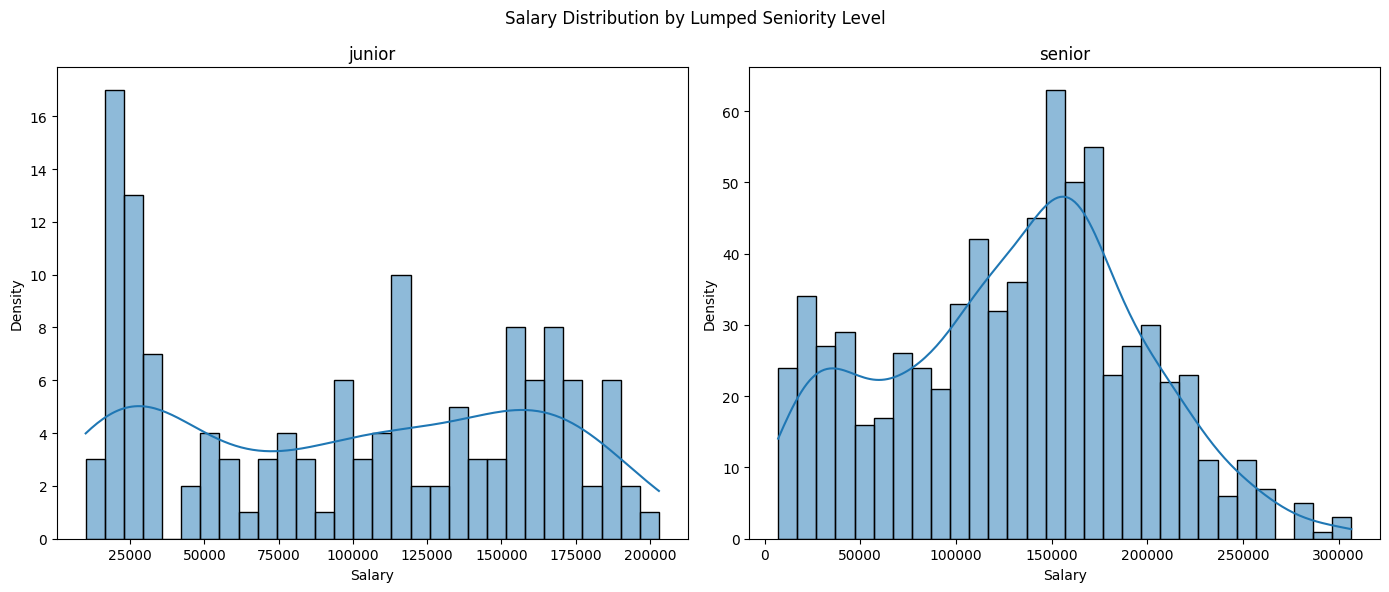

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=False)
axes = axes.flatten()
for ax, level in zip(axes, ['junior', 'senior']):
    sns.histplot(data=df_filtered[df_filtered['Seniority_Binary'] == level], x='Cleaned_Salary', bins=30, kde=True, ax=ax)
    ax.set_title(level)
    ax.set_xlabel('Salary')
    ax.set_ylabel('Density')

plt.suptitle('Salary Distribution by Lumped Seniority Level')
plt.tight_layout()
plt.show()

These are actually pretty interesting results. We can pretty clearly see that salaries in the "junior" category is not normally distributed.


The "Senior" category is closer to normal, but still has a bit of a right skew.


I'll be curious to see if particular skills are associated with identifiable distribution patterns...


<h3>Skills Analysis</h3>

To get started, I'll need to learn something about what skills are listed.

I took a look at the skills data, and I'm seeing that most entries are comma-separated lists of skills.

What I'd like to do is understand which individual skills appear most often for 'junior' roles and 'senior' roles.

I'll compare the top skills for both levels.

In [88]:
print('\nTop Skills for Junior and Senior DS Roles')
print(f"{'No.':<5} {'Junior Skill':<20} {'Count':<7} {'Senior Skill':<20} {'Count':<7}")
print("-" * 70)
for i in range(max(len(most_common_jr_skills), len(most_common_sr_skills))):
    jr_skill, jr_count = most_common_jr_skills[i]
    sr_skill, sr_count = most_common_sr_skills[i]
    print(f"{i+1:<5} {jr_skill:<20} {jr_count:<7} {sr_skill:<20} {sr_count:<7}")


Top Skills for Junior and Senior DS Roles
No.   Junior Skill         Count   Senior Skill         Count  
----------------------------------------------------------------------
1     python               115     python               522    
2     machine learning     106     machine learning     473    
3     sql                  73      sql                  367    
4     r                    53      r                    289    
5     aws                  29      aws                  187    
6     spark                26      deep learning        153    
7     deep learning        24      tensorflow           147    
8     database             21      azure                140    
9     tensorflow           17      spark                133    
10    pytorch              15      pytorch              133    
11    azure                13      tableau              103    
12    tableau              12      gcp                  95     
13    hadoop               10      scikit-learn       

For the most part, these lists are in agreement. I'm honestly a little surprised not to see more differentiation.

I think what would be interesting is to see which skills are associated with higher salaries within each experience level.

Let's start with junior roles.

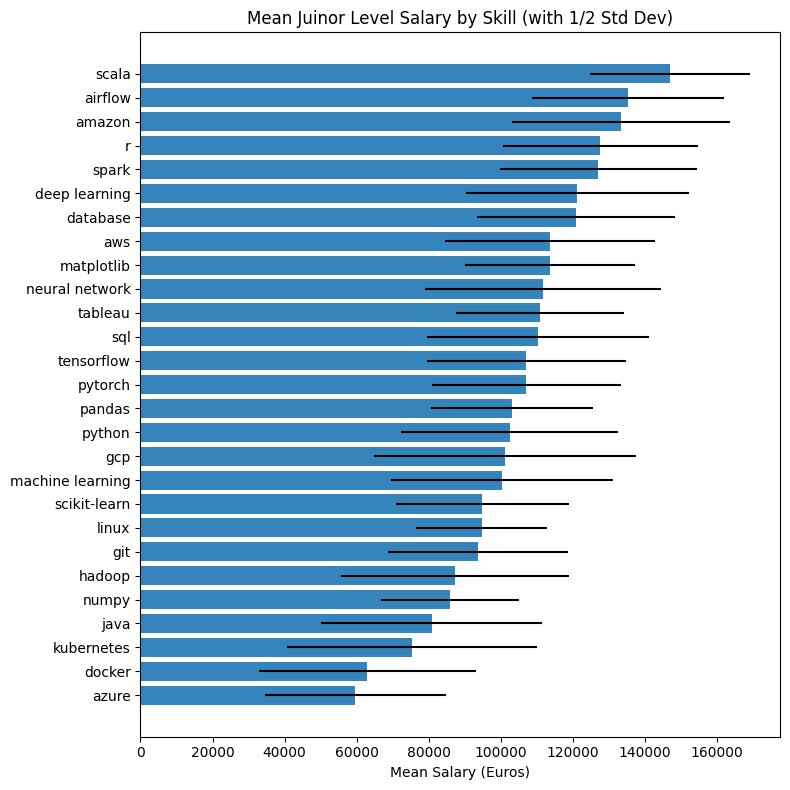

In [89]:
## Create a dictionary where each skill maps to a list of salaries for junior roles requiring that skill.
jr_skill_salary = {}
for skills, salary in zip(df_filtered[df_filtered['Seniority_Binary'] == 'junior']['skills'].dropna(), df_filtered[df_filtered['Seniority_Binary'] == 'junior']['Cleaned_Salary'].dropna()):
    skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
    for skill in skill_list:
        if skill not in jr_skill_salary:
            jr_skill_salary[skill] = []
        jr_skill_salary[skill].append(salary)

## Now let's get some summary stats for each skill.
jr_skill_salary_summary = {skill: (np.mean(salaries), np.median(salaries), np.std(salaries), len(salaries)) for skill, salaries in jr_skill_salary.items() if len(salaries) >= 2}
jr_skill_salary_summary_sorted = sorted(jr_skill_salary_summary.items(), key=lambda x: x[1][0], reverse=True)

## Now we have a dictionary containing skills and summary stats, sorted by mean salary.
## Let's print out a table with the top 25 skills and their associated salary stats.
# print('\nJunior Level DS Skills and Salary Stats')
# print(f"{'No.':<5} {'Skill':<20} {'Mean Salary':<15} {'Median Salary':<15} {'Std Dev':<10} {'Count':<7}")
# print("-" * 80)
# for i, (skill, (mean_salary, median_salary, std_dev, count)) in enumerate(jr_skill_salary_summary_sorted[:25]):
#     print(f"{i+1:<5} {skill:<20} {mean_salary:<15.2f} {median_salary:<15.2f} {std_dev:<10.2f} {count:<7}")

jr_skills_df = pd.DataFrame.from_dict(jr_skill_salary_summary, orient='index', columns=['mean_salary','median_salary','std_dev','count']).reset_index().rename(columns={'index':'skill'})

jr_skills_plot = jr_skills_df.sort_values('mean_salary', ascending=True)

fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(jr_skills_plot['skill'], jr_skills_plot['mean_salary'], xerr=(jr_skills_plot['std_dev']/2), color='C0', alpha=0.9)
ax.set_xlabel('Mean Salary (Euros)')
ax.set_title('Mean Juinor Level Salary by Skill (with 1/2 Std Dev)')
plt.tight_layout()
plt.show()
    

One thing I'm noticing is that these standard deviations are very high.

What this tells me is that the roles I've broadly classified as "junior" probably represent a wide range of actual experience levels.


My theory at this point would be that the top skills are really just the "tools of the trade" and that, for these junior roles at least,
there's unlikely to be a strong correlation between specific skills and salary. Also, pay for some of these jobs is shockingly low.
At some point later I might want to see if the covariance of skill pairs for some of these tops skills is better correlated with salary.

For now, I'll take a look at senior roles next and see if there's more differentiation there.

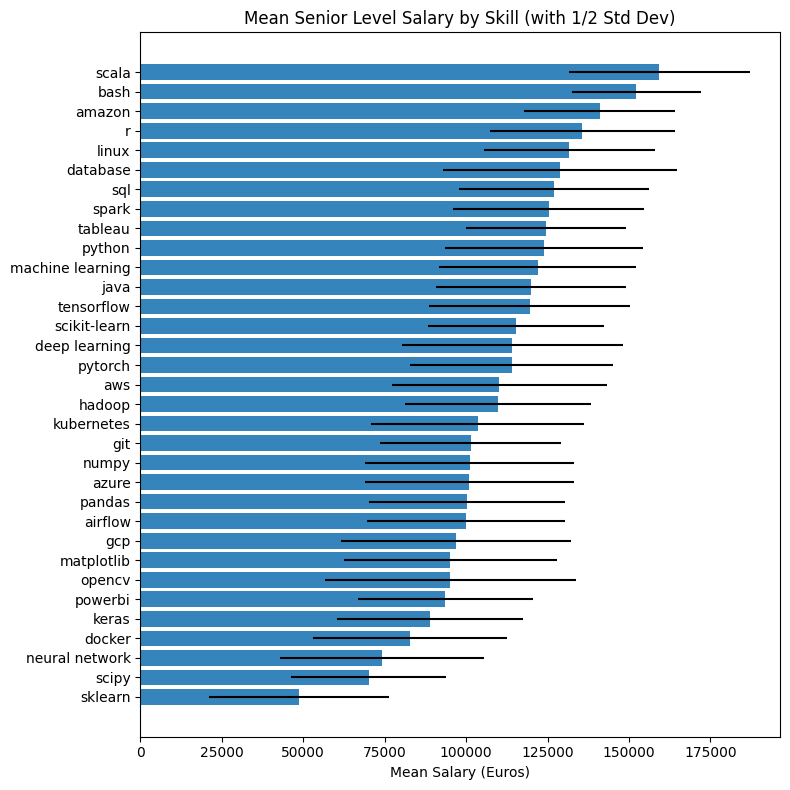

In [90]:
sr_skill_salary = {}
for skills, salary in zip(df_filtered[df_filtered['Seniority_Binary'] == 'senior']['skills'].dropna(), df_filtered[df_filtered['Seniority_Binary'] == 'senior']['Cleaned_Salary'].dropna()):
    skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
    for skill in skill_list:
        if skill not in sr_skill_salary:
            sr_skill_salary[skill] = []
        sr_skill_salary[skill].append(salary)


sr_skill_salary_summary = {skill: (np.mean(salaries), np.median(salaries), np.std(salaries), len(salaries)) for skill, salaries in sr_skill_salary.items() if len(salaries) >= 2}
sr_skill_salary_summary_sorted = sorted(sr_skill_salary_summary.items(), key=lambda x: x[1][0], reverse=True)

# print('\nSenior Level DS Skills and Salary Stats')
# print(f"{'No.':<5} {'Skill':<20} {'Mean Salary':<15} {'Median Salary':<15} {'Std Dev':<10} {'Count':<7}")
# print("-" * 80)
# for i, (skill, (mean_salary, median_salary, std_dev, count)) in enumerate(sr_skill_salary_summary_sorted[:25]):
#     print(f"{i+1:<5} {skill:<20} {mean_salary:<15.2f} {median_salary:<15.2f} {std_dev:<10.2f} {count:<7}")


sr_skills_df = pd.DataFrame.from_dict(sr_skill_salary_summary, orient='index', columns=['mean_salary','median_salary','std_dev','count']).reset_index().rename(columns={'index':'skill'})

sr_skills_plot = sr_skills_df.sort_values('mean_salary', ascending=True)

fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(sr_skills_plot['skill'], sr_skills_plot['mean_salary'], xerr=(sr_skills_plot['std_dev']/2), color='C0', alpha=0.9)
ax.set_xlabel('Mean Salary (Euros)')
ax.set_title('Mean Senior Level Salary by Skill (with 1/2 Std Dev)')
plt.tight_layout()
plt.show()


Ok, now we're getting somwhere.

Scala is obviously showing itself as a high-value skill. My bet is that this has to do with who is hiring.
That is to say, it's probably big companies who are utilizing Scala for large dataset processing, automations, etc.

I'll have to do more reasearch on that (and see if I can find a way to work with Scala for a project in my portfolio),
but the language itself doesn't really look to be that different from Python or R for data science tasks. If a company has already sunk
significant resources into Scala implementation, though, that would explain why they are willing to pay a premium for it.

Same is likely the case for Spark and some the other big data skills we're seeing here like 'amazon' and 'aws' that speak to the (cloud) infrastucture that companies have in place.

Interestingly, bash shows up in the senior skills, but not the junior skills. I would guess this is because senior roles are expected to own
more of the end-to-end data pipeline, which often involves some bash scripting for OS-level automations.

I'm also somewhat surprised not to see more generic skills (communication, teamwork, agile, MS Office, etc.).
Maybe these things aren't as necessary for these roles, as they might not be client-facing? or maybe they just assume everyone has them or they are more trainable on the job than technical skills?

<h3>Salary Distribution by Job Title</h3>

Now let's look at how salary distribution varies with job title.

The dataset contains only a single "data analyst" salary, and just three "data engineer" salaries.

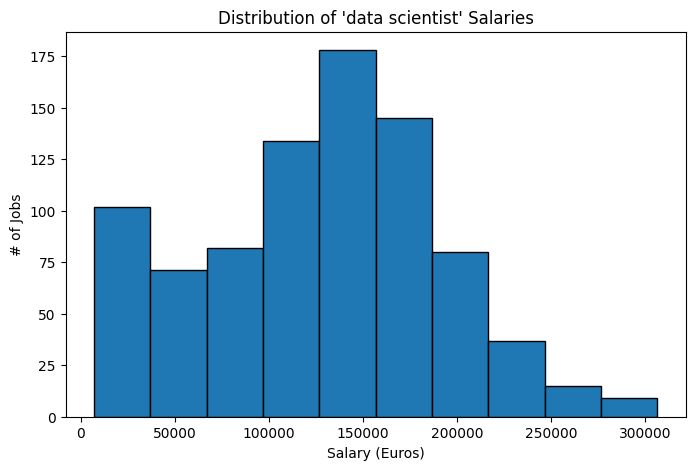

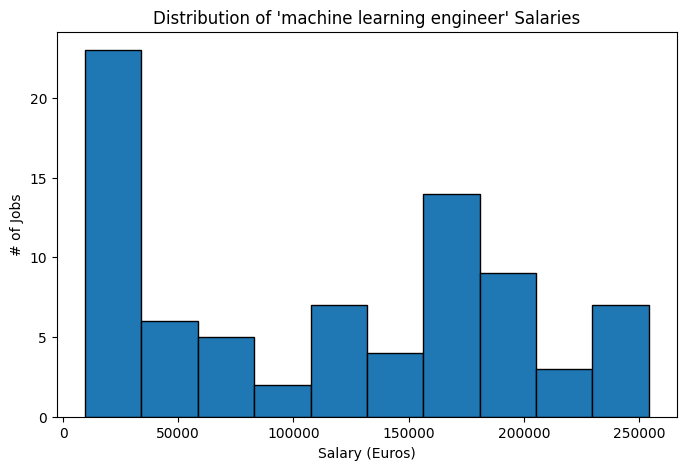

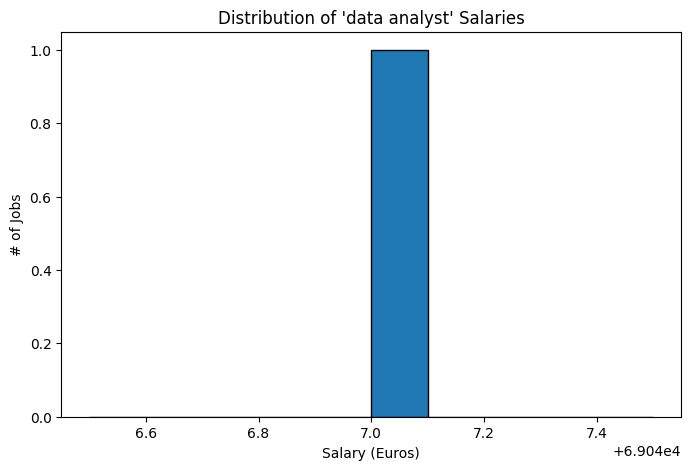

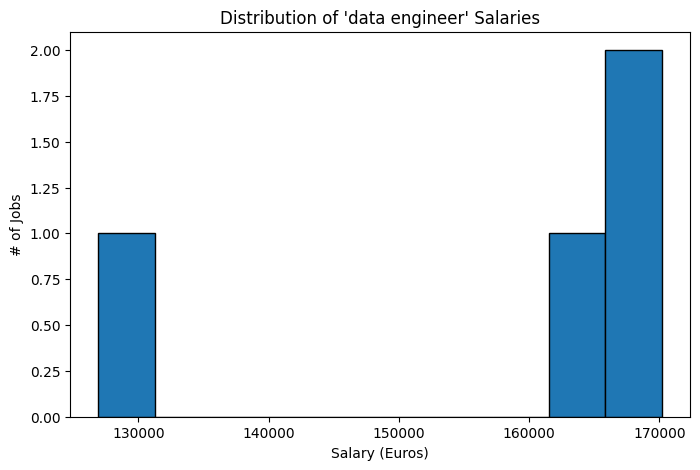

In [91]:
title_list = df['job_title'].dropna().unique()
title_counts = df['job_title'].dropna().value_counts()

for title in title_list:
        plt.figure(figsize=(8, 5))
        df_filtered[df_filtered['job_title']==title]['Cleaned_Salary'].plot.hist(bins=10, edgecolor = 'black')
        plt.xlabel('Salary (Euros)')
        plt.ylabel('# of Jobs')
        plt.title(f"Distribution of '{title}' Salaries")
        plt.grid(False)
        plt.show()

Ok, we have an idea of the range of salaries and how they are distributed by job title and seniority level. We also have an idea of the skills most commonly expected, and how they relate to mean salary.

I think maybe the next step should be to see how salaries and skills vary by industry.

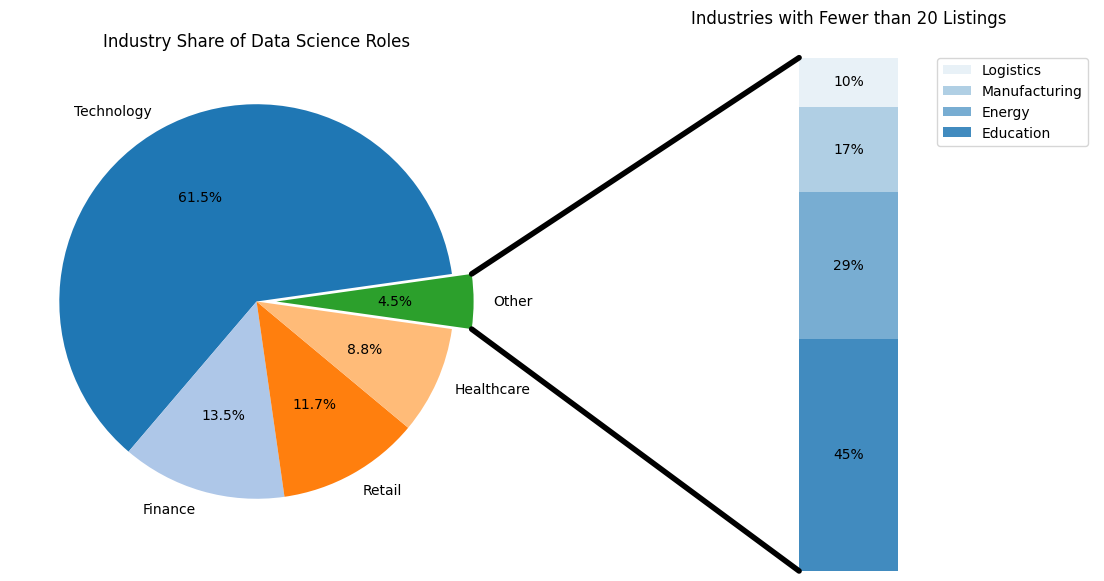

In [92]:
industries = df_filtered['industry'].dropna().unique()
industry_counts = df_filtered['industry'].dropna().value_counts()

## This time, I'll make a pie chart of industries represented in the dataset, combining industries with fewer than 20 listings into an "Other" category.
## Then, I'll add a bar of the "Other" slice so we can see how the smaller industries contribute without making the pie chart unreadable.

big_ind = industry_counts[industry_counts >= 20]
lil_ind = industry_counts[industry_counts < 20]
big_ind['Other'] = lil_ind.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

## pie chart params
pie_labels = big_ind.index
pie_sizes = big_ind.values
colors = plt.cm.tab20.colors[:len(pie_labels)]
explode = [0.1 if size == big_ind['Other'] else 0 for size in pie_sizes]
angle = 180*(pie_sizes.min()/sum(pie_sizes))
## took me a while to understand this next part, but this will capture the slices from the .pie() call and junk the other outputs into var '_'.
wedges, *_ = ax1.pie(pie_sizes, labels=pie_labels, autopct='%1.1f%%', startangle=angle, colors=colors, explode=explode)
ax1.set_title('Industry Share of Data Science Roles')

## bar chart params
bar_labels = lil_ind.index
bar_sizes = [v / sum(lil_ind.values) for v in lil_ind.values]
bottom = 1
width = 0.2

## stack bars to match legend order
for s, (height, label) in enumerate(reversed([*zip(bar_sizes, bar_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, label=label, color='C0', alpha = 0.1 + 0.25 * s)
    ## create bars
    ax2.bar_label(bc, labels = [f"{(height):.0%}"], label_type = 'center')

## bar chart info
ax2.set_title('Industries with Fewer than 20 Listings')
ax2.legend(loc = 'best', bbox_to_anchor=(1, 0.965))
ax2.axis('off')
ax2.set_xlim(-2.5*width, 2.5*width)

## Now we draw some lines connecting the pie to the bar chart.
## Theta values here represent the ends of the curve of the "Other" wedge that we'll be exploding and making a bar for.
theta1, theta2 = wedges[4].theta1, wedges[4].theta2
center, r = wedges[4].center, wedges[4].r
bar_height = sum(bar_sizes)

## draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

## draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

That ended up being a pretty good looking plot. We're seeing that tech dominates the field, followed by finance, retail, and healthcare.

What could explain this distribution? Tech would obviously be the industry most burdened with large datasets, so that makes sense.

Finance would also be a data-heavy industry, with the added pressure to derive valueable insights from data either for driving trade decisions,
risk management, fraud detection, or customer insights. Retail would also have a lot of data, especially e-commerce, and an interest in converting
that data into customer insights.

Healthcare is interesting, becuase I would assume that it's representation here is more about the similar pressures
on the industry to the others listed (lots of data, lots of customers, high cost of operation drives an emphasis on cost reduction and efficiency),
rather than a belief among healthcare companies that data science has a major role to play in directing care or R&D.

Next, I'll take a look at which skills are most commonly requested by industry.

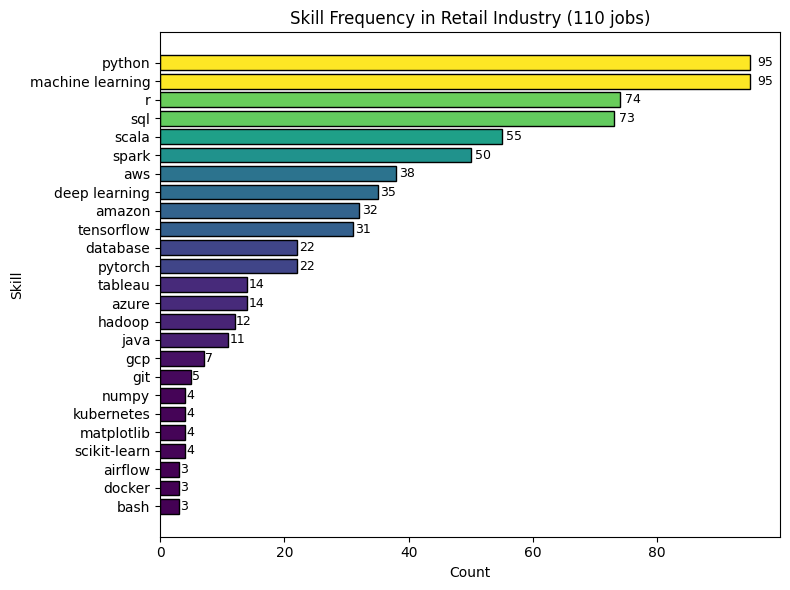

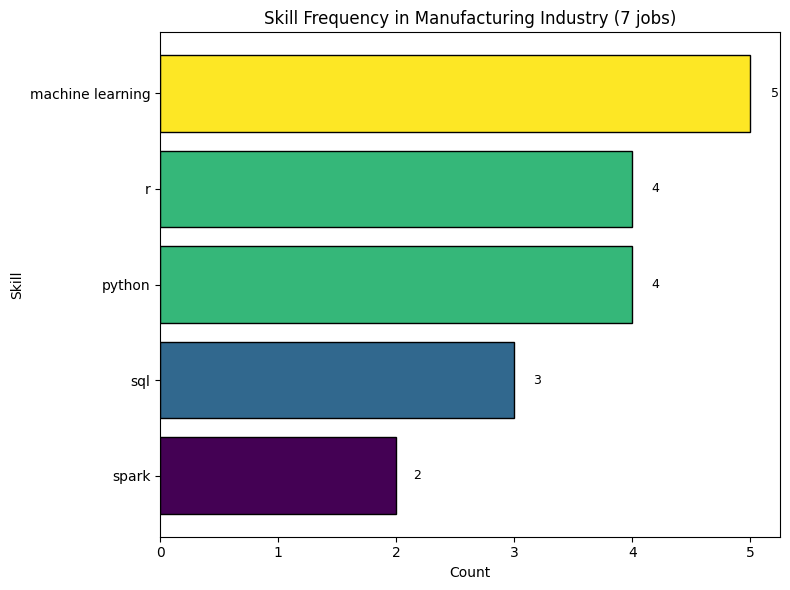

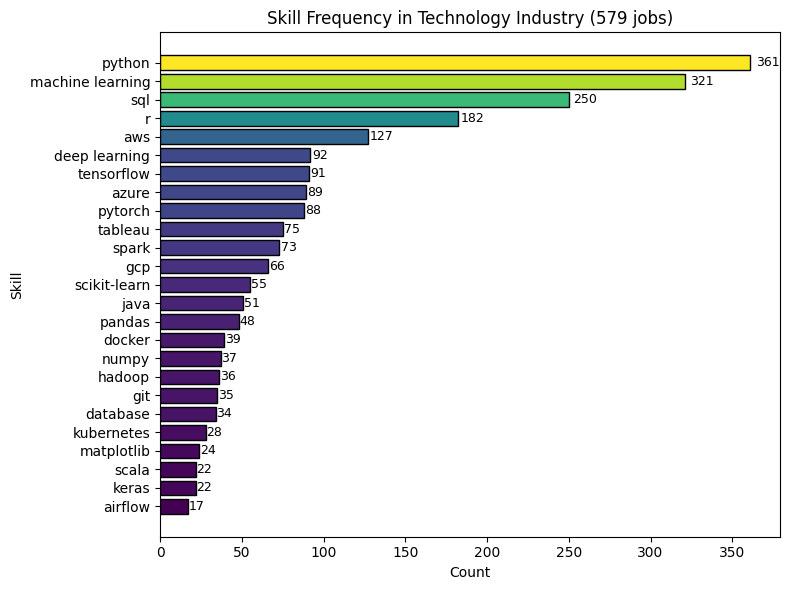

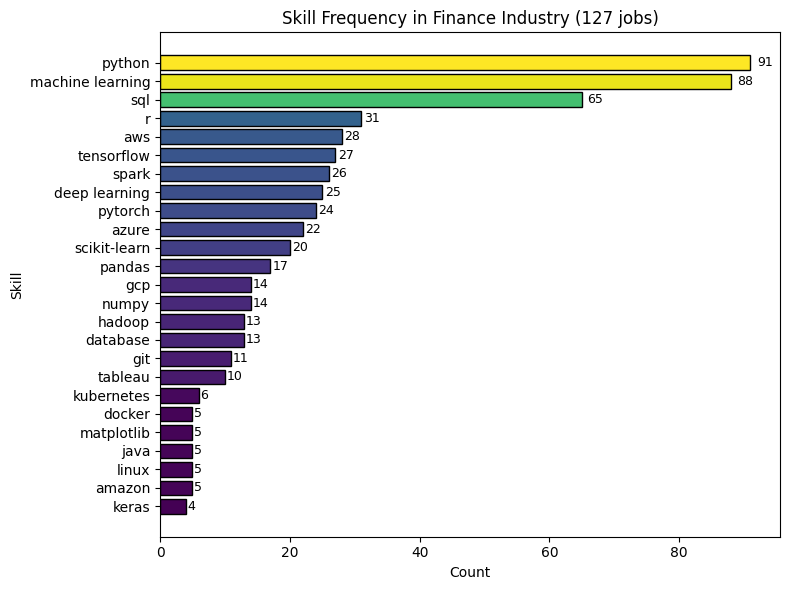

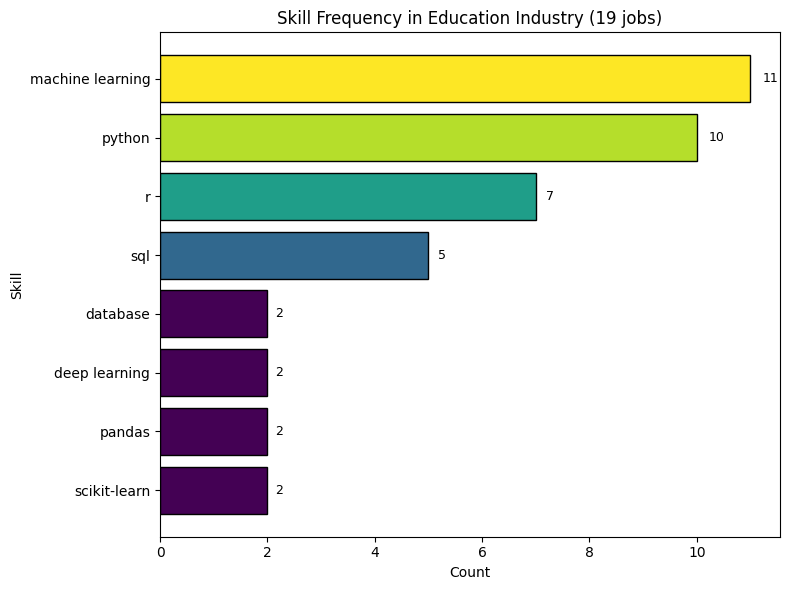

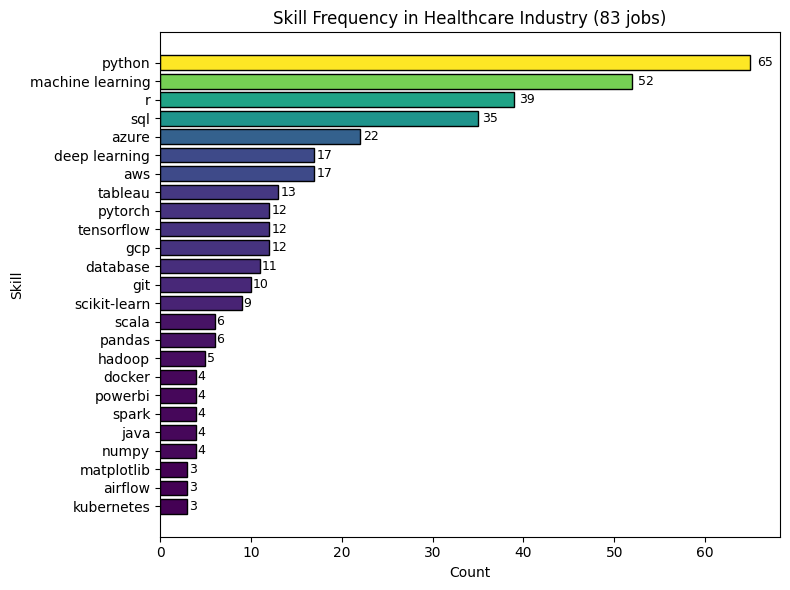

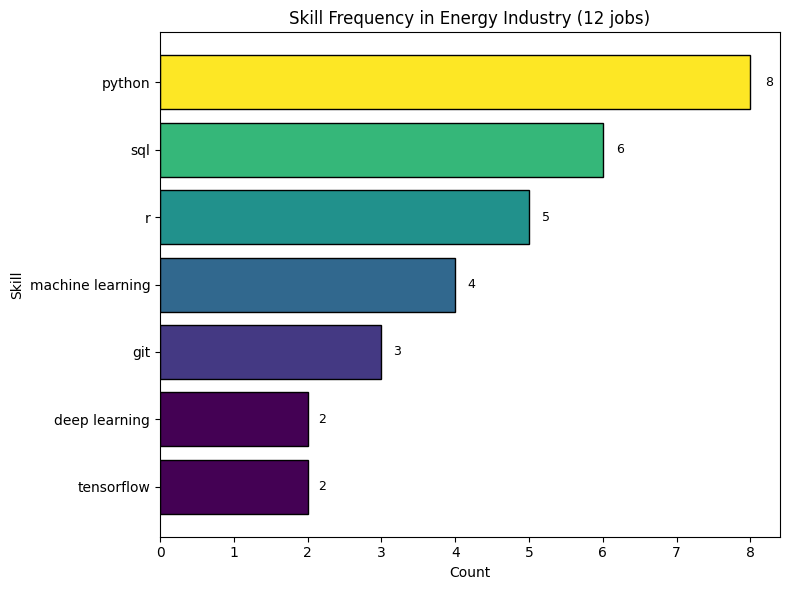

In [137]:
industry_skill_counter = {industry: Counter() for industry in industries}
for industry in industries:
    for skills in df_filtered[df_filtered['industry'] == industry]['skills'].dropna():
        skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
        industry_skill_counter[industry].update(skill_list)
most_common_industry_skills = {industry: counter.most_common(25) for industry, counter in industry_skill_counter.items()}

for industry, skills in most_common_industry_skills.items():
    if industry not in ['Logistics']:
        frequent_skills = [(skill, count) for skill, count in skills if count > 1]
        skill_list, counts = zip(*frequent_skills)
        skill_prop = np.array(counts)/(industry_counts[industry])

        norm = plt.Normalize(skill_prop.min(), skill_prop.max())
        cmap = plt.cm.viridis
        colors = cmap(norm(skill_prop))

        fig, ax = plt.subplots(figsize =(8, 6))
        ax.barh(skill_list, counts, color=colors, edgecolor='black')
        ax.set_title(f'Skill Frequency in {industry} Industry ({industry_counts[industry]} jobs)')
        ax.set_xlabel('Count')
        ax.set_ylabel('Skill')
        ax.invert_yaxis()
        for i, (skill, count) in enumerate(zip(skills, counts)):
            ax.text(count + ((0.01*count)+0.125), i, str(count), va='center', fontsize=9)
        plt.tight_layout()
        plt.show()

So, the most interesting thing I'm noticing here is Scala only appears as a top-ten skill in retail.
Explanding our view to the top 25 skills, Scala shows up in healthcare, tech, and energy as well.

Another intersting data point here is where we see deep learning as a major skill. This represents a real differentiation of the types
of data and insights sought by each industry. Retail, finance, tech, and healthcare all make sense here, as we can pretty easily intuit
the types of unstructured data (images, text, video, audio) that these industries would be handling, and how they might benefit from deep learning.

Although not as directly insightful at the scale of industry hiring trends, we can understand a difference in the types of roles being hired for
where we see skills like Tableau and Power BI. These are more business-intelligence oriented skills, suggesting roles that are more focused
on presenting data insights to business stakeholders, rather than or in addition to building data products or automations.

Appart from that, we're mostly seeing the same skills and the same rankings for each industry.
The big takeaway here is probably that if you want to get a job as a data scientist you should know python, SQL, and machine learning.
Beyond that some familiarty with big data tools and infrastructure (Hadoop, Spark, AWS, etc.) is probably a good idea.
Depending on the role, some knowledge of deep learning and/or business intelligence tools might be useful as well.

<h3>Revenues & Salaries</h3>

Now I want to look at the association of company revenue and salary.

Where both Cleaned_Salary and Cleaned_Revenue (created during data cleaning) are not null, I'll create a scatterplot of the relationship between salary and revenue.
To do that, I need a version of the dataframe that only has records where both values are not null.

In [60]:
df_revclean = df_filtered.dropna(subset=['Cleaned_Revenue', 'Cleaned_Salary']).copy()

The cleaned revenues need to be in a 2D array for the .fit() and .score() functions that we'll use for our linear regression and to generate an R-squared value, respectively.

In [61]:
X = df_revclean['Cleaned_Revenue'].values.reshape(-1,1)
Y = df_revclean['Cleaned_Salary'].values

Now we create the scatter plot and plot a trend line. 

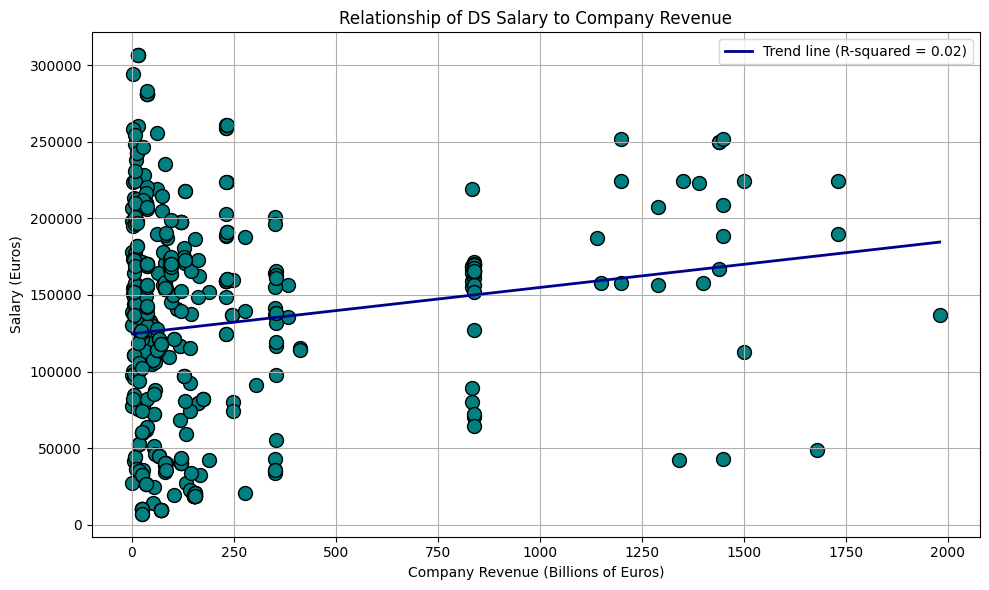

In [65]:
model = LinearRegression()
model.fit(X, Y)
## Get an R-squared value by predicting values based on trend line and compare to actual salaries.
## Like with X above, rev_range needs to be a 2D array for .predict()
rev_range = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
pred_sal = model.predict(rev_range)
r_squared = model.score(X, Y)
## create the scatter plot and plot the trend line labeled with R-squared value
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(df_revclean['Cleaned_Revenue'], df_revclean['Cleaned_Salary'], color='teal', edgecolor='black', s=100)
ax.plot(rev_range, pred_sal, color='darkblue', linewidth=2, label=f'Trend line (R-squared = {r_squared:.2f})')
ax.grid(True)
ax.legend()
plt.title('Relationship of DS Salary to Company Revenue')
plt.xlabel('Company Revenue (Billions of Euros)')
plt.ylabel('Salary (Euros)')
plt.tight_layout()
plt.show(block=False)

From this plot we see that company revenue is not at all a good predictor of DS role salaries. The smallest companies in terms of revenue
have some of the highest salaries in the dataset, and while the trend line suggests that bigger companies hire at slightly higher salaries,
the R-squared value tells us that this association is extremely weak in our dataset. This shows a couple of interesting things when taken
together with our previous insights: 

First, there are probably a good number of tech start-ups who are willing to pay a real premium for a 
skilled data science professional. 

Second, just because a company makes a lot of money, it does not mean that an applicant can expect a much
higher salary than they would receive from a smaller one. 

There is a clear pattern of higher variability among salaries at smaller companies, so that may be an important point of consideration for the applicant.

In [ ]:
## Now that I have cleaned up salary info, I think maybe we'll make a histogram of the salaries.
df_filtered['Cleaned_Salary'].plot.hist(bins=30, edgecolor='black')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Data Scientist Salaries')
plt.grid(True)
plt.show(block = False)  

## I'd like to see what the distribution of salaries is like when broken down by experience level.
## I'll make a boxplot for this. 

plt.figure(figsize=(10, 6))
sns.boxplot(x='seniority_level', y='Cleaned_Salary', data=df_filtered, showmeans=True, meanline=True)
plt.xlabel('Experience Level')
plt.ylabel('Salary')
plt.title('Salary Distribution by Experience Level')
plt.grid(True)
plt.show(block = False)

## The boxplot suggests that "junior" and "midlevel" might not really be meaningful distinctions.
## For now, I think I'd like to make histograms of salaries by experience level all shown together in one window as separate plots.

experience_levels = df_filtered['seniority_level'].dropna().unique()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5), sharey=False)
axes = axes.flatten()
for ax, level in zip(axes, experience_levels):
    sns.histplot(data=df_filtered[df_filtered['seniority_level'] == level], x='Cleaned_Salary', bins=30, kde=True, ax=ax)
    ax.set_title(level)
    ax.set_xlabel('Salary')
    ax.set_ylabel('Density')

plt.suptitle('Salary Distribution by Experience Level')
plt.tight_layout()
plt.show(block = False)

## These plots make it clearer that "junior" has far fewer records than the other categories, and distributions are not exactly normal.
## I'll try recategorizing seniority_level into just "junior" and "senior" (combining midlevel and senior) and see how that looks.

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=False)
axes = axes.flatten()
for ax, level in zip(axes, ['junior', 'senior']):
    sns.histplot(data=df_filtered[df_filtered['Seniority_Binary'] == level], x='Cleaned_Salary', bins=30, kde=True, ax=ax)
    ax.set_title(level)
    ax.set_xlabel('Salary')
    ax.set_ylabel('Density')

plt.suptitle('Salary Distribution by Lumped Experience Level')
plt.tight_layout()
plt.show(block = False)

input('Press Enter to continue...')

## These are actually pretty interesting results. We can pretty clearly see that the "junior" category is not normally distributed.
## The "Senior" category is closer to normal, but still has a bit of a right skew.
## I'll be curious to see if particular skills are associated with identifiable distribution patterns.

## To get started, I'll need to learn something about what skills are listed.
## I took a look at the skills data, and I'm seeing that most entries are comma-separated lists of skills.
## What I'd like to do is understand which individual skills appear most often for 'junior' roles and 'senior' roles.
## I'll compare the top skills for both levels.
print('\nTop Skills for Junior and Senior DS Roles')
print(f"{'No.':<5} {'Junior Skill':<20} {'Count':<7} {'Senior Skill':<20} {'Count':<7}")
print("-" * 70)
for i in range(max(len(most_common_jr_skills), len(most_common_sr_skills))):
    jr_skill, jr_count = most_common_jr_skills[i]
    sr_skill, sr_count = most_common_sr_skills[i]
    print(f"{i+1:<5} {jr_skill:<20} {jr_count:<7} {sr_skill:<20} {sr_count:<7}")

## For the most part, these lists are in agreement. I'm honestly a little surprised not to see more differentiation.
## I think what would be interesting is to see which skills are associated with higher salaries within each experience level.
## Let's start with junior roles.
jr_skill_salary = {}
for skills, salary in zip(df_filtered[df_filtered['Seniority_Binary'] == 'junior']['skills'].dropna(), df_filtered[df_filtered['Seniority_Binary'] == 'junior']['Cleaned_Salary'].dropna()):
    skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
    for skill in skill_list:
        if skill not in jr_skill_salary:
            jr_skill_salary[skill] = []
        jr_skill_salary[skill].append(salary)

## What that did was create a dictionary where each skill maps to a list of salaries for junior roles requiring that skill.
## Now let's get some summary stats for each skill.
jr_skill_salary_summary = {skill: (np.mean(salaries), np.median(salaries), np.std(salaries), len(salaries)) for skill, salaries in jr_skill_salary.items() if len(salaries) >= 2}
jr_skill_salary_summary_sorted = sorted(jr_skill_salary_summary.items(), key=lambda x: x[1][0], reverse=True)
## Now we have a dictionary containing skills and summary stats, sorted by mean salary.
## Let's print out a table with the top 25 skills and their associated salary stats.
print('\nJunior Level DS Skills and Salary Stats')
print(f"{'No.':<5} {'Skill':<20} {'Mean Salary':<15} {'Median Salary':<15} {'Std Dev':<10} {'Count':<7}")
print("-" * 80)
for i, (skill, (mean_salary, median_salary, std_dev, count)) in enumerate(jr_skill_salary_summary_sorted[:25]):
    print(f"{i+1:<5} {skill:<20} {mean_salary:<15.2f} {median_salary:<15.2f} {std_dev:<10.2f} {count:<7}")
    
## One thing I'm noticing is that these standard deviations are very high.
## What this tells me is that the roles I've broadly classified as "junior" probably represent a wide range of actual experience levels.
## My theory at this point would be that the top skills are really just the "tools of the trade" and that, for these junior roles at least,
## there's unlikely to be a strong correlation between specific skills and salary. Also, pay for some of these jobs is shockingly low.
## At some point later I might want to see if the covariance of skill pairs for some of these tops skills is better correlated with salary.
## For now, I'll take a look at senior roles next and see if there's more differentiation there.
sr_skill_salary = {}
for skills, salary in zip(df_filtered[df_filtered['Seniority_Binary'] == 'senior']['skills'].dropna(), df_filtered[df_filtered['Seniority_Binary'] == 'senior']['Cleaned_Salary'].dropna()):
    skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
    for skill in skill_list:
        if skill not in sr_skill_salary:
            sr_skill_salary[skill] = []
        sr_skill_salary[skill].append(salary)


sr_skill_salary_summary = {skill: (np.mean(salaries), np.median(salaries), np.std(salaries), len(salaries)) for skill, salaries in sr_skill_salary.items() if len(salaries) >= 2}
sr_skill_salary_summary_sorted = sorted(sr_skill_salary_summary.items(), key=lambda x: x[1][0], reverse=True)

print('\nSenior Level DS Skills and Salary Stats')
print(f"{'No.':<5} {'Skill':<20} {'Mean Salary':<15} {'Median Salary':<15} {'Std Dev':<10} {'Count':<7}")
print("-" * 80)
for i, (skill, (mean_salary, median_salary, std_dev, count)) in enumerate(sr_skill_salary_summary_sorted[:25]):
    print(f"{i+1:<5} {skill:<20} {mean_salary:<15.2f} {median_salary:<15.2f} {std_dev:<10.2f} {count:<7}")

## Ok, now we're getting somwhere. Scala is obviously showing itself as a high-value skill. My bet is that this has to do with who is hiring.
## That is to say, it's probably big companies who are utilizing Scala for large dataset processing, automations, etc.
## I'll have to do more reasearch on that (and see if I can find a way to work with Scala for a project in my portfolio),
## but the language itself doesn't really look to be that different from Python or R for data science tasks. If a company has already sunk
## significant resources into Scala, though, that would explain why they are willing to pay a premium for it.
## Same is likely the case for Spark and some the other big data tools we're seeing here.
## Interestingly, bash shows up in the senior skills, but not the junior skills. I would guess this is because senior roles are expected to own
## more of the end-to-end data pipeline, which often involves some bash scripting for OS-level automations.
## I'm also somewhat surprised not to see more generic skills (communication, teamwork, agile, MS Office, etc.).
## Maybe these things aren't as necessary for these roles, as they might not be client-facing? or maybe they just assume everyone has them?


## Let's look at job titles next.
title_list = df['job_title'].dropna().unique()
title_counts = df['job_title'].dropna().value_counts()

for title in title_list:
        plt.figure(figsize=(8, 5))
        df_filtered[df_filtered['job_title']==title]['Cleaned_Salary'].plot.hist(bins=10, edgecolor = 'black')
        plt.xlabel('Salary')
        plt.ylabel('Frequency')
        plt.title(f"Distribution of {title} Salaries")
        plt.grid(True)
        plt.show(block = False)

input('Press Enter to continue...')

## Ok, we have an idea of the range of salaries and how they are distributed. We have an idea of the skills most commonly expected.
## I think maybe the next step should be to see how salaries and skills vary by industry.

industries = df_filtered['industry'].dropna().unique()
industry_counts = df_filtered['industry'].dropna().value_counts()

## This time, I'll make a pie chart of industries represented in the dataset, combining industries with fewer than 20 listings into an "Other."
## Then, I'll add a bar of the "other" slice so we can see how the smaller industries contibute without making the pie chart unreadable.

from matplotlib.patches import ConnectionPatch

big_ind = industry_counts[industry_counts >= 20]
lil_ind = industry_counts[industry_counts < 20]
big_ind['Other'] = lil_ind.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

## pie chart params
pie_labels = big_ind.index
pie_sizes = big_ind.values
colors = plt.cm.tab20.colors[:len(pie_labels)]
explode = [0.1 if size == big_ind['Other'] else 0 for size in pie_sizes]
angle = 180*(pie_sizes.min()/sum(pie_sizes))
## took me a while to understand this next part, but this will capture the slices from the .pie() call and junk the other outputs into var '_'.
wedges, *_ = ax1.pie(pie_sizes, labels=pie_labels, autopct='%1.1f%%', startangle=angle, colors=colors, explode=explode)

## bar chart params
bar_labels = lil_ind.index
bar_sizes = [v / sum(lil_ind.values) for v in lil_ind.values]
bottom = 1
width = 0.2

## stack bars to match legend order
for s, (height, label) in enumerate(reversed([*zip(bar_sizes, bar_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, label=label, color='C0', alpha = 0.1 + 0.25 * s)
    ## create bars
    ax2.bar_label(bc, labels = [f"{height:.0%}"], label_type = 'center')

## bar chart info
ax2.set_title('Industries with Fewer than 20 Listings')
ax2.legend(loc = 'best', bbox_to_anchor=(1, 0.965))
ax2.axis('off')
ax2.set_xlim(-2.5*width, 2.5*width)

## Now we draw some lines connecting the pie to the bar chart.
## Not sure that this will be drawing to the correct spots, but we'll see.
theta1, theta2 = wedges[4].theta1, wedges[4].theta2
center, r = wedges[4].center, wedges[4].r
bar_height = sum(bar_sizes)

## draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

## draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show(block = False)
input('Press Enter to exit...')

## That ended up being a pretty good looking plot. We're seeing that tech dominates the field, followed by finance, retail, and healthcare.
## What could explain this distribution? Tech would obviously be the industry most burdened with large datasets, so that makes sense.
## Finance would also be a data-heavy industry, with the added pressure to derive valueable insights from data either for driving trade decisions,
## risk management, fraud detection, or customer insights. Retail would also have a lot of data, especially e-commerce, and an interest in converting
## that data into customer insights. Healthcare is interesting, becuase I would assume that it's representation here is more about the similar pressures
## on the industry to the others listed (lots of data, lots of customers, high cost of operation drives an emphasis on cost reduction and efficiency),
## rather than a belief among healthcare companies that data science has a major role to play in directing care or R&D.

## Next, I'll take a look at which skills are most commonly requested by industry.
industry_skill_counter = {industry: Counter() for industry in industries}
for industry in industries:
    for skills in df_filtered[df_filtered['industry'] == industry]['skills'].dropna():
        skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
        industry_skill_counter[industry].update(skill_list)
most_common_industry_skills = {industry: counter.most_common(25) for industry, counter in industry_skill_counter.items()}
for industry, skills in most_common_industry_skills.items():
    print(f"\nMost common skills for {industry} industry:")
    for skill, count in skills:
        print(f"{skill}: {count}")

## So, the most interesting thing I'm noticing here is Scala only appears as a top-ten skill in retail.
## My suspicion is that it would show up more if we were looking at more than ten skills per industry. Let me take a look at that now...
## Yup, when we look at the top 25 skills, Scala shows up in healthcare, tech, and energy as well.

## Another intersting data point here is where we see deep learning as a major skill. This represents a real differentiation of the types
## of data and insights sought by each industry. Retail, finance, tech, and healthcare all make sense here, as we can pretty easily intuit
## the types of unstructured data (images, text, video, audio) that these industries would be handling, and how they might benefit from deep learning.

## Although not as directly insightful at the scale of industry hiring trends, we can understand a difference in the types of roles being hired for
## where we see skills like tableau and power bi. These are more business-intelligence focused skills, suggesting roles that are more focused
## on presenting data insights to business stakeholders, rather than or in addition to building data products or automations.

## Appart from that, we're mostly seeing the same skills and the same rankings for each industry.
## The big takeaway here is probably that if you want to get a job as a data scientist you should know python, SQL, and machine learning.
## Beyond that some familiarty with big data tools and infrastructure (Hadoop, Spark, AWS, etc.) is probably a good idea.
## Depending on the role, some knowledge of deep learning and/or business intelligence tools might be useful as well.

## Now I want to look at the association of company revenue and salary.
## Like we did for salaries before, we'll need to clean up the revenues field using a custom function.

def rev_clean(rev):
         if pd.isna(rev):
             return np.nan
         if rev in ['Public', 'Private', 'Education', 'Nonprofit']:
             return np.nan
         rev = rev.replace('€', '').replace(',', '').strip()
         if rev.endswith('B'):
             return float(rev[:-1])
         if rev.endswith('T'):
             return float(rev[:-1])*1000
         if rev.endswith('M'):
             return float(rev[:-1])/1000

## This will remove the € symbol and the trailing M, T, and B values while converting all values to floats (in billions of Euros).
## Now we'll apply this to the revenues field.
df_filtered.loc[:,'Cleaned_Revenue'] = df_filtered['revenue'].apply(rev_clean).astype(float)
## Next, where both Cleaned_Salary and Cleaned_Revenue are not null, I'll create a scatterplot of the relationship between salary and revenue.
## To do that, I need a version of the dataframe that only has records where both values are not null
df_revclean = df_filtered.dropna(subset=['Cleaned_Revenue', 'Cleaned_Salary']).copy()
## The cleaned revenues need to be in a 2D array for the .fit() and .score() functions
X = df_revclean['Cleaned_Revenue'].values.reshape(-1,1)
Y = df_revclean['Cleaned_Salary'].values
## Next I'll create the scatter plot and plot a trend line. 
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, Y)
## Get an R-squared value by predicting values based on trend line and compare to actual salaries.
## Like with X above, rev_range needs to be a 2D array for .predict()
rev_range = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
pred_sal = model.predict(rev_range)
r_squared = model.score(X, Y)
## creat the scatter plot and plot the trend line labeled with R-squared value
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(df_revclean['Cleaned_Revenue'], df_revclean['Cleaned_Salary'], color='teal', edgecolor='black', s=100)
ax.plot(rev_range, pred_sal, color='darkorange', linewidth=2, label=f'Trend line (R-squared = {r_squared:.2f})')
ax.grid(True)
ax.legend()
plt.title('Relationship of DS Salary to Company Revenue')
plt.xlabel('Company Revenue (Billions of Euros)')
plt.ylabel('Salary (Euros)')
plt.tight_layout()
plt.show(block=False)
input('Press enter to exit...')

## From this plot we see that company revenue is not at all a good predictor of DS role salaries. The smallest companies in terms of revenue
## have some of the highest salaries in the dataset, and while the trend line suggests that bigger companies hire at slightly higher salaries,
## the R-squared value tells us that this association is extremely weak in our dataset. This shows a couple of interesting things when taken
## together with our previous insights: First, there are probably a good number of tech start-ups who are willing to pay a real premium for a 
## skilled data science professional. Second, just because a company makes a lot of money, it does not mean that an applicant can expect a much
## higher salary than they would receive from a smaller one. There is a clear pattern of higher variability among salaries at smaller companies,
## so that may be an important point of consideration for the applicant.

<center><h2><strong>Advanced Analysis</strong></h2><center>

In [ ]:
## TBC, this section will contain analysis of skills and salaries for Junior and Senior DS roles.


<center><h2><strong>Conclusions</strong></h2></center>

This cell will contain takeaways. It might even make sense to have all of the editorial comments from the EDA section moved into here...